# Student Graduation Prediction
In this notebook, we will look at if combining the two targets; Enrolled and Graduate, could make the model predict more accurately.

The main goal of the model we are trying to make is to predict whether someone will drop out or not. Therefore, it is not that interesting finding out if a student is either enrolled or graduated, and perhaps the models could perform better when these targets are combined.

In [2]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV

from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import shap

In [3]:
df = pd.read_csv('data/data.csv',sep=";")

target_map = {'Dropout': 1, 'Enrolled': 0, 'Graduate': 0}
y = df['Target'].map(target_map).astype(int).values
class_names = ['Not Dropped Out', 'Dropped Out']

X = df.drop(columns=['Target'])

In [4]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # ratios
        X["approval_ratio_1st"] = X["Curricular units 1st sem (approved)"] / X["Curricular units 1st sem (enrolled)"].replace(0, np.nan)
        X["approval_ratio_2nd"] = X["Curricular units 2nd sem (approved)"] / X["Curricular units 2nd sem (enrolled)"].replace(0, np.nan)
        # avg grade across semesters (ignore zeros)
        X["avg_grade"] = X[["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]].replace(0, np.nan).mean(axis=1)
        # totals & overall ratio
        X["total_approved"] = X["Curricular units 1st sem (approved)"] + X["Curricular units 2nd sem (approved)"]
        X["total_enrolled"] = X["Curricular units 1st sem (enrolled)"] + X["Curricular units 2nd sem (enrolled)"]
        X["total_approval_ratio"] = X["total_approved"] / X["total_enrolled"].replace(0, np.nan)

        X["approval_diff"] = X["approval_ratio_2nd"] - X["approval_ratio_1st"]
        X["grade_diff"] = X["Curricular units 2nd sem (grade)"] - X["Curricular units 1st sem (grade)"]

        return X.fillna(0.0)

X = X.fillna(0)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
def printResults(name,y_test,y_pred,y_proba):
    print("\n=== " + name + " ===")
    print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
    print("ROC-AUC:", f"{roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

In [27]:
catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="Accuracy",
    random_state=42,
    verbose=False
)

pipe_catboost = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", catboost_clf),
])

pipe_catboost.fit(X_train, y_train)
y_pred_cat = pipe_catboost.predict(X_test)

printResults("CatBoost", y_test, y_pred_cat, pipe_catboost.predict_proba(X_test)[:, 1])


=== CatBoost ===
Accuracy: 0.8904
ROC-AUC: 0.9400
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.94      0.92       601
    Dropped Out       0.86      0.78      0.82       284

       accuracy                           0.89       885
      macro avg       0.88      0.86      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[566  35]
 [ 62 222]]


### Learning from the Model
It is also important to look at what features makes the most impact on the model. Beneath, we will look at the top 10 most important features for the model above. We will also have a look at which features could be harmful and see if removing those features could improve performance.

ROC-AUC: 0.9400


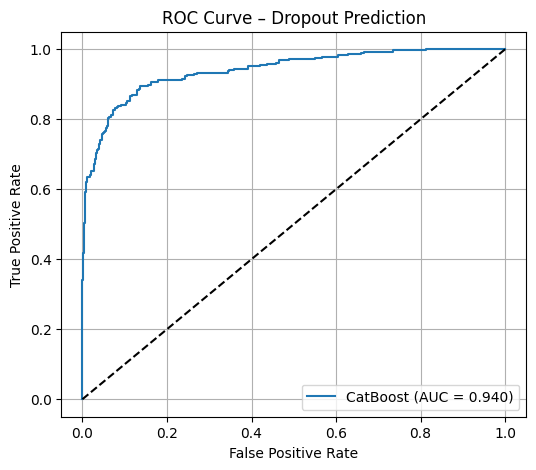

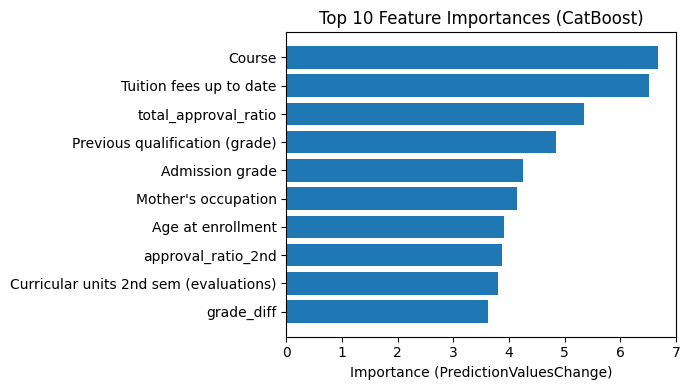


Top 10 important features:

                               Feature  Importance
                                Course    6.675009
               Tuition fees up to date    6.517877
                  total_approval_ratio    5.354484
        Previous qualification (grade)    4.852049
                       Admission grade    4.258894
                   Mother's occupation    4.149279
                     Age at enrollment    3.907443
                    approval_ratio_2nd    3.871421
Curricular units 2nd sem (evaluations)    3.806817
                            grade_diff    3.623931


In [28]:
y_proba = pipe_catboost.predict_proba(X_test)[:, 1]
y_true = y_test

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Dropout Prediction")
plt.legend()
plt.grid(True)
plt.show()

fe = pipe_catboost.named_steps["fe"]
X_test_transformed = fe.transform(X_test)
feature_names = list(X_test_transformed.columns)

cat = pipe_catboost.named_steps["clf"]
importances = np.array(cat.feature_importances_)

importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
      .sort_values("Importance", ascending=False)
      .head(10)
)

plt.figure(figsize=(7, 4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (CatBoost)")
plt.xlabel("Importance (PredictionValuesChange)")
plt.tight_layout()
plt.show()

print("\nTop 10 important features:\n")
print(importance_df.to_string(index=False))

Features potentially hurting the model (lowest permutation importance):
                                           Feature  Importance_Mean  \
8                           Mother's qualification        -0.000835   
26  Curricular units 1st sem (without evaluations)        -0.000328   
32  Curricular units 2nd sem (without evaluations)        -0.000199   
4                     Daytime/evening attendance\t        -0.000097   
14                       Educational special needs        -0.000082   
23          Curricular units 1st sem (evaluations)        -0.000048   
7                                      Nationality        -0.000016   
20                                   International        -0.000006   
1                                 Application mode         0.000075   
5                           Previous qualification         0.000163   

    Importance_Std  
8         0.000653  
26        0.000553  
32        0.000120  
4         0.000043  
14        0.000140  
23        0.000892  

C:\Users\willi\AppData\Local\Temp\ipykernel_41940\2868227141.py:23: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\PycharmProjects\tdt4259\.venvv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


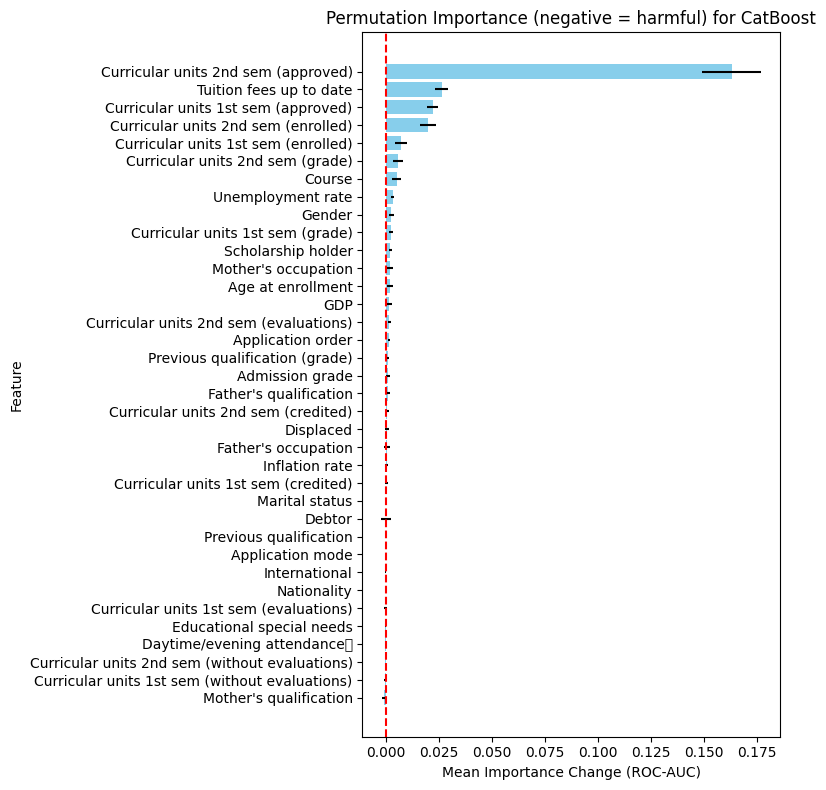

In [29]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    pipe_catboost, X_test, y_test,
    scoring="roc_auc", n_repeats=5, random_state=42, n_jobs=-1
)

imp_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_Mean": r.importances_mean,
    "Importance_Std": r.importances_std
}).sort_values("Importance_Mean", ascending=True)

print("Features potentially hurting the model (lowest permutation importance):")
print(imp_df.head(10))

plt.figure(figsize=(8, 8))
plt.barh(imp_df["Feature"], imp_df["Importance_Mean"], xerr=imp_df["Importance_Std"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.title("Permutation Importance (negative = harmful) for CatBoost")
plt.xlabel("Mean Importance Change (ROC-AUC)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [30]:
harmful_features = [
    "Mother's qualification",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (without evaluations)",
    "Daytime/evening attendance\t",
    "Educational special needs",
    "Curricular units 1st sem (evaluations)",
    "Nationality",
    "International",
]

X_cleaned = X.drop(columns=harmful_features, errors="ignore")

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cleaned, y, stratify=y, test_size=0.2, random_state=42
)

pipe_catboost_clean = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", catboost_clf),
])

pipe_catboost_clean.fit(X_train_c, y_train_c)
y_pred_c = pipe_catboost_clean.predict(X_test_c)
y_proba_c = pipe_catboost_clean.predict_proba(X_test_c)[:, 1]

printResults("CatBoost (Cleaned Feature Set)", y_test_c, y_pred_c, y_proba_c)


=== CatBoost (Cleaned Feature Set) ===
Accuracy: 0.8893
ROC-AUC: 0.9385
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.94      0.92       601
    Dropped Out       0.86      0.78      0.82       284

       accuracy                           0.89       885
      macro avg       0.88      0.86      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[565  36]
 [ 62 222]]


### Hyperparameter tuning


In [32]:
cat_base = CatBoostClassifier(
    loss_function="Logloss",
    random_state=42,
    verbose=False,
    thread_count=-1,
)

pipe_cat = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", cat_base),
])

f1_pos = make_scorer(f1_score, average="binary", pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "clf__iterations": [500, 800, 1000],
    "clf__learning_rate": [0.03, 0.05, 0.07],
    "clf__depth": [5, 6, 7, 8],
    "clf__l2_leaf_reg": [3, 5, 7, 9],
    "clf__bagging_temperature": [0.0, 0.25, 0.5, 1.0],
    "clf__bootstrap_type": ["Bayesian"],
    "clf__random_strength": [1, 2, 3],
    "clf__auto_class_weights": ["Balanced"],
}

search = RandomizedSearchCV(
    estimator=pipe_cat,
    param_distributions=param_dist,
    n_iter=40,
    scoring=f1_pos,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,
)

search.fit(X_train, y_train)

best_cat = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best F1 (Dropped Out):", f"{search.best_score_:.4f}")

y_pred_cat_tuned = best_cat.predict(X_test)

printResults("CatBoost (tuned)", y_test, y_pred_cat_tuned, best_cat.predict_proba(X_test)[:, 1])

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'clf__random_strength': 2, 'clf__learning_rate': 0.03, 'clf__l2_leaf_reg': 5, 'clf__iterations': 1000, 'clf__depth': 7, 'clf__bootstrap_type': 'Bayesian', 'clf__bagging_temperature': 0.0, 'clf__auto_class_weights': 'Balanced'}
CV best F1 (Dropped Out): 0.8024

=== CatBoost (tuned) ===
Accuracy: 0.8825
ROC-AUC: 0.9385
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.91      0.91       601
    Dropped Out       0.82      0.82      0.82       284

       accuracy                           0.88       885
      macro avg       0.87      0.87      0.87       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[549  52]
 [ 52 232]]


In [25]:
p_val = best_cat.predict_proba(X_train)[:, 1]
p_test = best_cat.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_train, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1): {thr_best:.3f}")

y_pred_thr = (p_test >= thr_best).astype(int)

printResults("CatBoost (tuned + threshold)", y_test, y_pred_thr, best_cat.predict_proba(X_test)[:, 1])

Chosen threshold (best F1): 0.518

=== CatBoost (tuned + threshold) ===
Accuracy: 0.8791
ROC-AUC: 0.9385
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.92      0.91       601
    Dropped Out       0.82      0.80      0.81       284

       accuracy                           0.88       885
      macro avg       0.86      0.86      0.86       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[551  50]
 [ 57 227]]


In [17]:
catboost_f1 = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="TotalF1",
    iterations=1500,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    auto_class_weights="Balanced",
    random_seed=42,
    od_type="Iter",
    od_wait=80,
    use_best_model=True,
    verbose=False,
)

catboost_f1.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred_cb_f1 = catboost_f1.predict(X_test)

printResults("CatBoost (F1-optimized)", y_test, y_pred_cb_f1, catboost_f1.predict_proba(X_test)[:, 1])


=== CatBoost (F1-optimized) ===
Accuracy: 0.8723
ROC-AUC: 0.9292
                 precision    recall  f1-score   support

Not Dropped Out       0.92      0.89      0.90       601
    Dropped Out       0.78      0.83      0.81       284

       accuracy                           0.87       885
      macro avg       0.85      0.86      0.86       885
   weighted avg       0.87      0.87      0.87       885

Confusion matrix:
 [[536  65]
 [ 48 236]]


In [18]:
n0, n1 = (y_train == 0).sum(), (y_train == 1).sum()
w_ratio = (n0 / n1) * 1.2

catboost_weighted = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    class_weights=[1.0, w_ratio],
    random_seed=42,
    verbose=False,
)

catboost_weighted.fit(X_train, y_train)
y_pred_weighted = catboost_weighted.predict(X_test)

printResults("CatBoost (weighted 1.2× dropout)", y_test, y_pred_weighted, catboost_weighted.predict_proba(X_test)[:, 1])


=== CatBoost (weighted 1.2× dropout) ===
Accuracy: 0.8847
ROC-AUC: 0.9315
                 precision    recall  f1-score   support

Not Dropped Out       0.92      0.91      0.92       601
    Dropped Out       0.82      0.82      0.82       284

       accuracy                           0.88       885
      macro avg       0.87      0.87      0.87       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[549  52]
 [ 50 234]]


In [23]:
n0, n1 = (y_train == 0).sum(), (y_train == 1).sum()
w_ratio = (n0 / n1) * 1.2

cat_final = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="TotalF1",
    iterations=1500,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    class_weights=[1.0, w_ratio],
    random_seed=42,
    od_type="Iter",
    od_wait=80,
    use_best_model=True,
    verbose=False,
)

cat_final.fit(X_train, y_train, eval_set=(X_test, y_test))

p_test = cat_final.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, p_test)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1): {thr_best:.3f}")

y_pred_thr = (p_test >= thr_best).astype(int)

printResults("CatBoost (final combined)", y_test, y_pred_thr, cat_final.predict_proba(X_test)[:, 1])

Chosen threshold (best F1): 0.610

=== CatBoost (final combined) ===
Accuracy: 0.8814
ROC-AUC: 0.9320
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.93      0.91       601
    Dropped Out       0.83      0.79      0.81       284

       accuracy                           0.88       885
      macro avg       0.87      0.86      0.86       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[556  45]
 [ 60 224]]


## Final Model without Removal of Features

In [21]:
cb_params = dict(
    iterations=1000,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    auto_class_weights="Balanced",
    loss_function="Logloss",
    eval_metric="Logloss",
    random_seed=42,
    verbose=False,
    thread_count=-1
)

cat_clf = CatBoostClassifier(**cb_params)

base_pipe_cb = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", cat_clf),
])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
tr_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

calibrated_cb = CalibratedClassifierCV(base_pipe_cb, method="isotonic", cv=3)
calibrated_cb.fit(X_tr, y_tr)

p_val = calibrated_cb.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1 on val): {thr_best:.3f}")

p_test = calibrated_cb.predict_proba(X_test)[:, 1]
y_pred_thr = (p_test >= thr_best).astype(int)
printResults("CatBoost (tuned + calibrated + threshold)", y_test, y_pred_thr, calibrated_cb.predict_proba(X_test)[:, 1])

Chosen threshold (best F1 on val): 0.263

=== CatBoost (tuned + calibrated + threshold) ===
Accuracy: 0.8780
ROC-AUC: 0.9394
                 precision    recall  f1-score   support

Not Dropped Out       0.94      0.87      0.91       601
    Dropped Out       0.77      0.89      0.82       284

       accuracy                           0.88       885
      macro avg       0.86      0.88      0.87       885
   weighted avg       0.89      0.88      0.88       885

Confusion matrix:
 [[525  76]
 [ 32 252]]


### Confusion Matrix

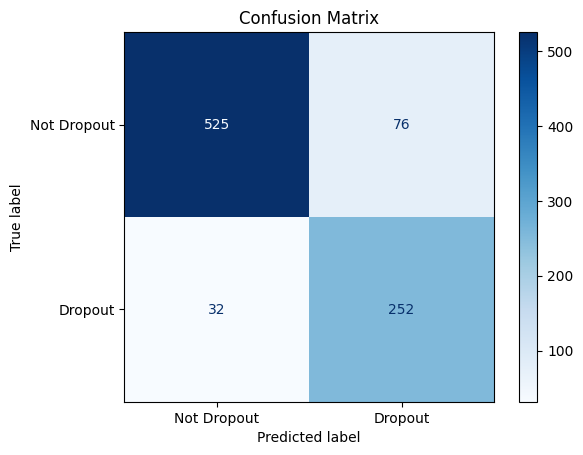

In [16]:
cm = confusion_matrix(y_true, y_pred_thr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Dropout', 'Dropout'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### ROC Curve

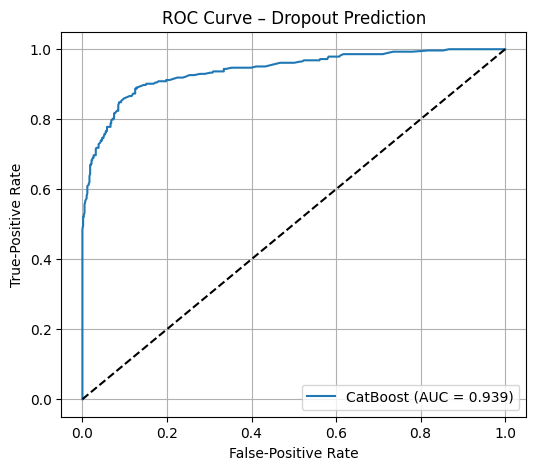

In [21]:
roc_auc = roc_auc_score(y_test, p_test)

fpr, tpr, _ = roc_curve(y_test, p_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve – Dropout Prediction")
plt.legend()
plt.grid(True)
plt.show()

### SHAP

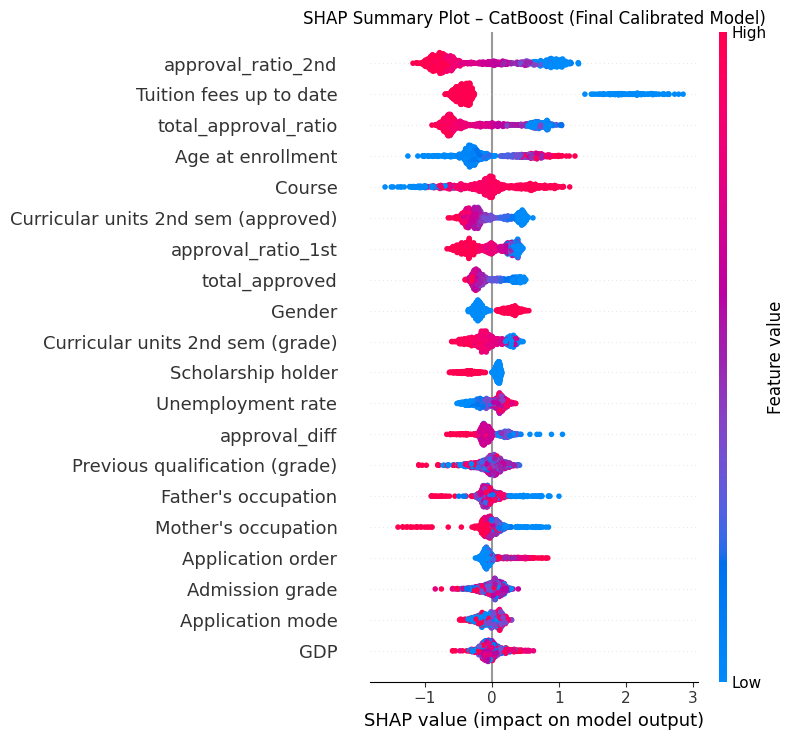

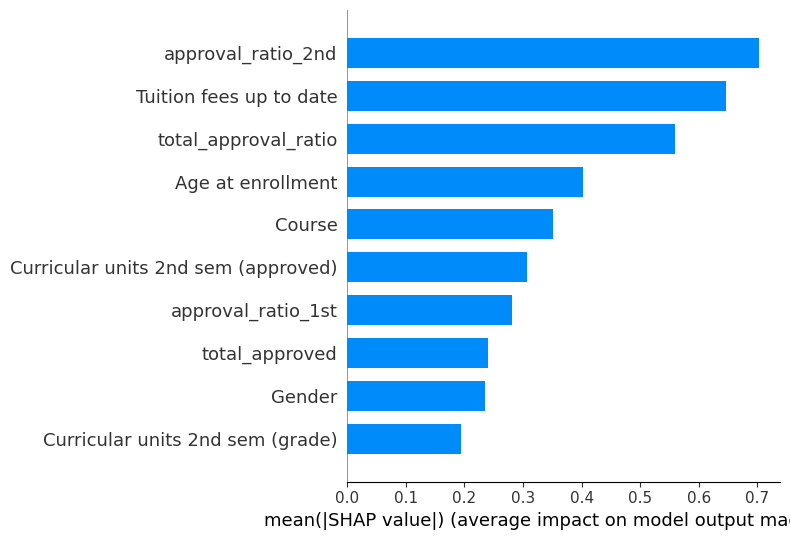

In [31]:
inner_calibrated = calibrated_cb.calibrated_classifiers_[0]
final_pipe = inner_calibrated.estimator

fe = final_pipe.named_steps["fe"]
clf = final_pipe.named_steps["clf"]

X_test_fe = fe.transform(X_test)
feature_names = list(X_test_fe.columns)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_fe)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

if shap_values.shape[1] == X_test_fe.shape[1] + 1:
    shap_values = shap_values[:, :-1]

plt.title("SHAP Summary Plot – CatBoost (Final Calibrated Model)")
shap.summary_plot(shap_values, X_test_fe, feature_names=feature_names, show=True, plot_size=0.3)

shap.summary_plot(
    shap_values, X_test_fe, feature_names=feature_names,
    plot_type="bar", max_display=10, show=True
)

### Robustness
#### Subgroup Performance

In [22]:
def subgroup_performance(X_test, y_test, model, group_col):
    results = []
    for value in sorted(X_test[group_col].unique()):
        idx = X_test[group_col] == value
        y_true_sub = y_test[idx]
        y_pred_sub = model.predict(X_test[idx])
        f1 = f1_score(y_true_sub, y_pred_sub, pos_label=1)
        results.append({'Group': group_col, 'Value': value, 'F1 (Dropout)': f1, 'n': len(y_true_sub)})
    return pd.DataFrame(results)

attend_df = subgroup_performance(X_test, y_test, calibrated_cb, 'Daytime/evening attendance\t')
course_df = subgroup_performance(X_test, y_test, calibrated_cb, 'Course')

table = pd.concat([attend_df, course_df])
table

,Group,Value,F1 (Dropout),n
0,Daytime/evening attendance\t,0,0.883721,97
1,Daytime/evening attendance\t,1,0.797327,788
0,Course,33,0.571429,6
1,Course,171,0.697674,47
2,Course,8014,0.848485,46
3,Course,9003,0.914286,42
4,Course,9070,0.800000,34
5,Course,9085,0.842105,54
6,Course,9119,0.769231,33
7,Course,9130,0.923077,27


#### Stability under Feature removal

In [45]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

# --- Your candidate features to drop (keep the exact names, including the \t) ---
low_importance = [
    "Mother's qualification",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (without evaluations)",
    "Application order",
    "Daytime/evening attendance\t",
    "Educational special needs",
    "Curricular units 1st sem (evaluations)",
    "Nationality",
    "International"
]

POS_LABEL = 1  # 1 = Dropout in your encoding

def eval_subset_holdout(model, X_train, y_train, X_test, y_test, drop_cols):
    Xtr = X_train.drop(columns=list(drop_cols), errors="ignore")
    Xte = X_test.drop(columns=list(drop_cols), errors="ignore")
    m = clone(model)
    m.fit(Xtr, y_train)
    yhat = m.predict(Xte)
    return f1_score(y_test, yhat, pos_label=POS_LABEL)

def eval_subset_cv(model, X_train, y_train, drop_cols, cv_splits=5, random_state=42):
    Xtr = X_train.drop(columns=list(drop_cols), errors="ignore")
    m = clone(model)
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(
        m, Xtr, y_train,
        scoring='f1',  # binary f1 with positive class=1 assumed by scikit when y is 0/1
        cv=cv,
        n_jobs=-1
    )
    return float(np.mean(scores)), float(np.std(scores))

# --- Baseline (no drops) ---
# Hold-out:
y_pred_full = calibrated_cb.predict(X_test)
f1_full_holdout = f1_score(y_test, y_pred_full, pos_label=POS_LABEL)

# CV:
f1_full_cv_mean, f1_full_cv_std = eval_subset_cv(calibrated_cb, X_train, y_train, drop_cols=[])

print(f"Baseline (hold-out) F1_Dropout: {f1_full_holdout:.3f}")
print(f"Baseline (5-fold CV) F1_Dropout: {f1_full_cv_mean:.3f} ± {f1_full_cv_std:.3f}")

# --- Exhaustive search for subset sizes 1..3 (manageable) ---
rows_holdout = []
rows_cv = []

for k in [1, 2, 3]:
    for subset in combinations(low_importance, k):
        # Hold-out
        f1_h = eval_subset_holdout(calibrated_cb, X_train, y_train, X_test, y_test, subset)
        rows_holdout.append({
            "drop_k": k,
            "dropped": subset,
            "F1_holdout": f1_h,
            "ΔF1_holdout": f1_h - f1_full_holdout
        })
        # CV
        f1_mean, f1_std = eval_subset_cv(calibrated_cb, X_train, y_train, subset)
        rows_cv.append({
            "drop_k": k,
            "dropped": subset,
            "F1_cv_mean": f1_mean,
            "F1_cv_std": f1_std,
            "ΔF1_cv": f1_mean - f1_full_cv_mean
        })

df_holdout = pd.DataFrame(rows_holdout).sort_values(["drop_k", "ΔF1_holdout"], ascending=[True, False])
df_cv = pd.DataFrame(rows_cv).sort_values(["drop_k", "ΔF1_cv"], ascending=[True, False])

print("\nTop (hold-out) improvements by k:")
print(df_holdout.groupby("drop_k").head(5)[["drop_k","dropped","F1_holdout","ΔF1_holdout"]])

print("\nTop (CV) improvements by k:")
print(df_cv.groupby("drop_k").head(5)[["drop_k","dropped","F1_cv_mean","F1_cv_std","ΔF1_cv"]])

# --- Optional: random search for larger subsets (k=4..6) ---
import random
random.seed(42)

def random_subset_search(k, n_samples=60):
    out_h, out_cv = [], []
    for _ in range(n_samples):
        subset = tuple(sorted(random.sample(low_importance, k)))
        f1_h = eval_subset_holdout(calibrated_cb, X_train, y_train, X_test, y_test, subset)
        f1_mean, f1_std = eval_subset_cv(calibrated_cb, X_train, y_train, subset)
        out_h.append({"drop_k": k, "dropped": subset, "F1_holdout": f1_h, "ΔF1_holdout": f1_h - f1_full_holdout})
        out_cv.append({"drop_k": k, "dropped": subset, "F1_cv_mean": f1_mean, "F1_cv_std": f1_std, "ΔF1_cv": f1_mean - f1_full_cv_mean})
    return pd.DataFrame(out_h), pd.DataFrame(out_cv)

dfs_h, dfs_cv = [], []
for k in [4, 5, 6]:
    h, c = random_subset_search(k, n_samples=80)  # bump to 150+ if you like
    dfs_h.append(h); dfs_cv.append(c)

if dfs_h:
    df_holdout_large = pd.concat(dfs_h).sort_values(["drop_k","ΔF1_holdout"], ascending=[True, False])
    df_cv_large = pd.concat(dfs_cv).sort_values(["drop_k","ΔF1_cv"], ascending=[True, False])

    print("\nRandom search (hold-out), top by k:")
    print(df_holdout_large.groupby("drop_k").head(5)[["drop_k","dropped","F1_holdout","ΔF1_holdout"]])

    print("\nRandom search (CV), top by k:")
    print(df_cv_large.groupby("drop_k").head(5)[["drop_k","dropped","F1_cv_mean","F1_cv_std","ΔF1_cv"]])

# --- Nice compact summary of best combos overall (CV-first) ---
best_cv = df_cv.sort_values("ΔF1_cv", ascending=False).head(10)
best_holdout = df_holdout.sort_values("ΔF1_holdout", ascending=False).head(10)

print("\n=== Best (CV) subsets ===")
print(best_cv[["drop_k","dropped","F1_cv_mean","F1_cv_std","ΔF1_cv"]])

print("\n=== Best (hold-out) subsets ===")
print(best_holdout[["drop_k","dropped","F1_holdout","ΔF1_holdout"]])

Baseline (hold-out) F1_Dropout: 0.811
Baseline (5-fold CV) F1_Dropout: 0.793 ± 0.014

Top (hold-out) improvements by k:
     drop_k                                            dropped  F1_holdout  \
2         1  (Curricular units 2nd sem (without evaluations),)    0.828096   
0         1                          (Mother's qualification,)    0.827068   
7         1                                     (Nationality,)    0.822222   
1         1  (Curricular units 1st sem (without evaluations),)    0.821764   
3         1                               (Application order,)    0.820225   
9         2  (Mother's qualification, Curricular units 1st ...    0.830258   
10        2  (Mother's qualification, Curricular units 2nd ...    0.825516   
37        2        (Daytime/evening attendance\t, Nationality)    0.825279   
11        2        (Mother's qualification, Application order)    0.823748   
13        2  (Mother's qualification, Educational special n...    0.823091   
91        3  (Curricul

KeyboardInterrupt: 

In [53]:
low_importance = [
    "Mother's qualification",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (without evaluations)",
    "Application order",
    "International"
]

y_pred_full = calibrated_cb.predict(X_test)
f1_full = f1_score(y_test, y_pred_full, pos_label=1)
print("Baseline F1 (Dropout):", round(f1_full, 3))

X_test_reduced = X_test.drop(columns=low_importance, errors="ignore")
X_train_reduced = X_train.drop(columns=low_importance, errors="ignore")

model_reduced = clone(calibrated_cb)
model_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = model_reduced.predict(X_test_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced, pos_label=1)

print("Reduced F1 (Dropout):", round(f1_reduced, 3))
print("Δ F1 after feature removal:", round(f1_full - f1_reduced, 3))

Baseline F1 (Dropout): 0.811
Reduced F1 (Dropout): 0.83
Δ F1 after feature removal: -0.018


## Final Model with Removal of Features

In [7]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns or []
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.columns, errors="ignore")

In [22]:
cb_params = dict(
    iterations=1000,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    auto_class_weights="Balanced",
    loss_function="Logloss",
    eval_metric="Logloss",
    random_seed=42,
    verbose=False,
    thread_count=-1
)

cat_clf = CatBoostClassifier(**cb_params)

# These performed the best and gave overall better recall:
drop_features = [
    "Curricular units 2nd sem (without evaluations)",
    "International",
]

base_pipe_cb = ImbPipeline([
    ("drop", DropColumns(columns=drop_features)),
    ("fe", FeatureEngineer()),
    ("clf", cat_clf),
])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
tr_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

calibrated_cb_rm = CalibratedClassifierCV(base_pipe_cb, method="isotonic", cv=3)
calibrated_cb_rm.fit(X_tr, y_tr)

p_val = calibrated_cb_rm.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1 on val): {thr_best:.3f}")

p_test = calibrated_cb_rm.predict_proba(X_test)[:, 1]
y_pred_thr = (p_test >= thr_best).astype(int)
printResults(
    "CatBoost (tuned + calibrated + threshold, reduced features)",
    y_test, y_pred_thr, calibrated_cb_rm.predict_proba(X_test)[:, 1]
)

Chosen threshold (best F1 on val): 0.260

=== CatBoost (tuned + calibrated + threshold, reduced features) ===
Accuracy: 0.8802
ROC-AUC: 0.9402
                 precision    recall  f1-score   support

Not Dropped Out       0.94      0.88      0.91       601
    Dropped Out       0.77      0.89      0.83       284

       accuracy                           0.88       885
      macro avg       0.86      0.88      0.87       885
   weighted avg       0.89      0.88      0.88       885

Confusion matrix:
 [[527  74]
 [ 32 252]]


### Confusion Matrix

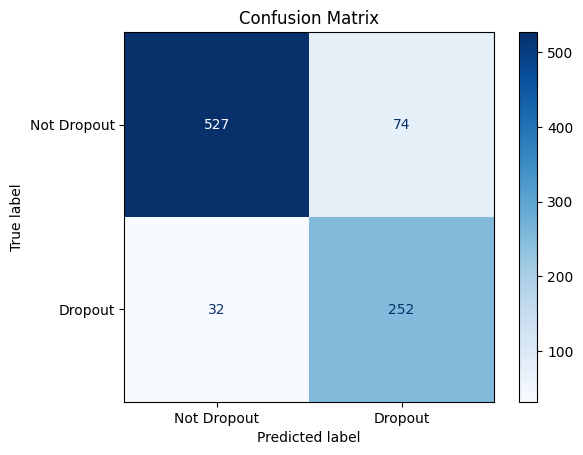

In [23]:
cm = confusion_matrix(y_test, y_pred_thr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Dropout', 'Dropout'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### ROC Curve

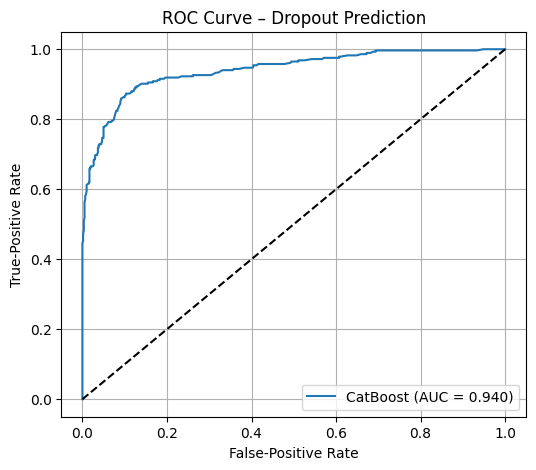

In [24]:
roc_auc = roc_auc_score(y_test, p_test)

fpr, tpr, _ = roc_curve(y_test, p_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve – Dropout Prediction")
plt.legend()
plt.grid(True)
plt.show()

### SHAP

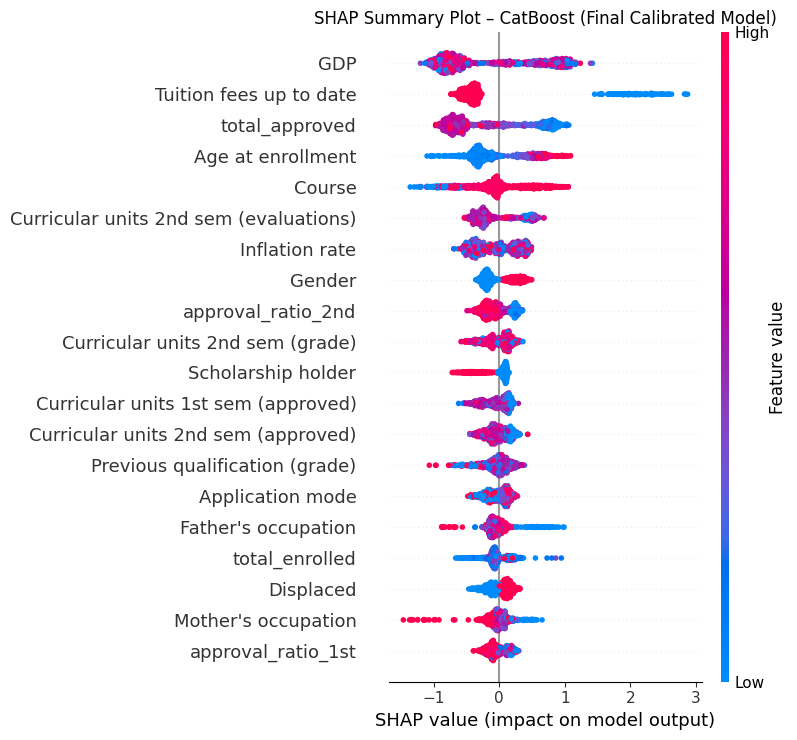

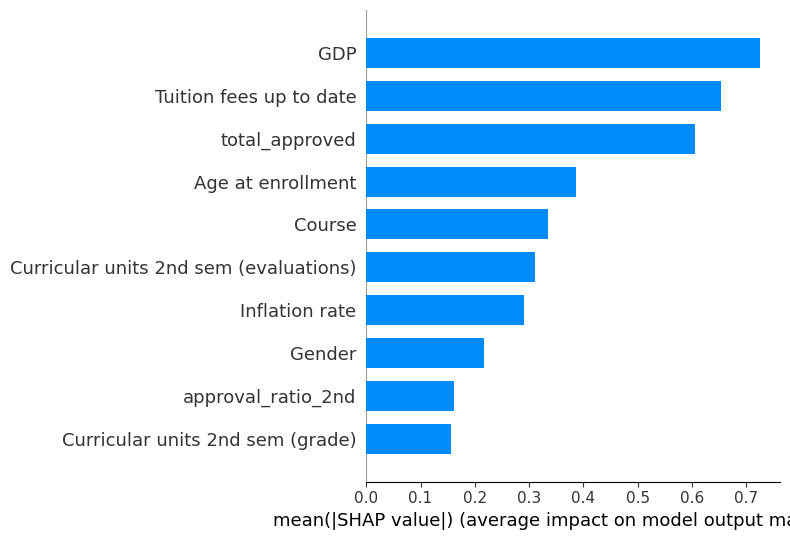

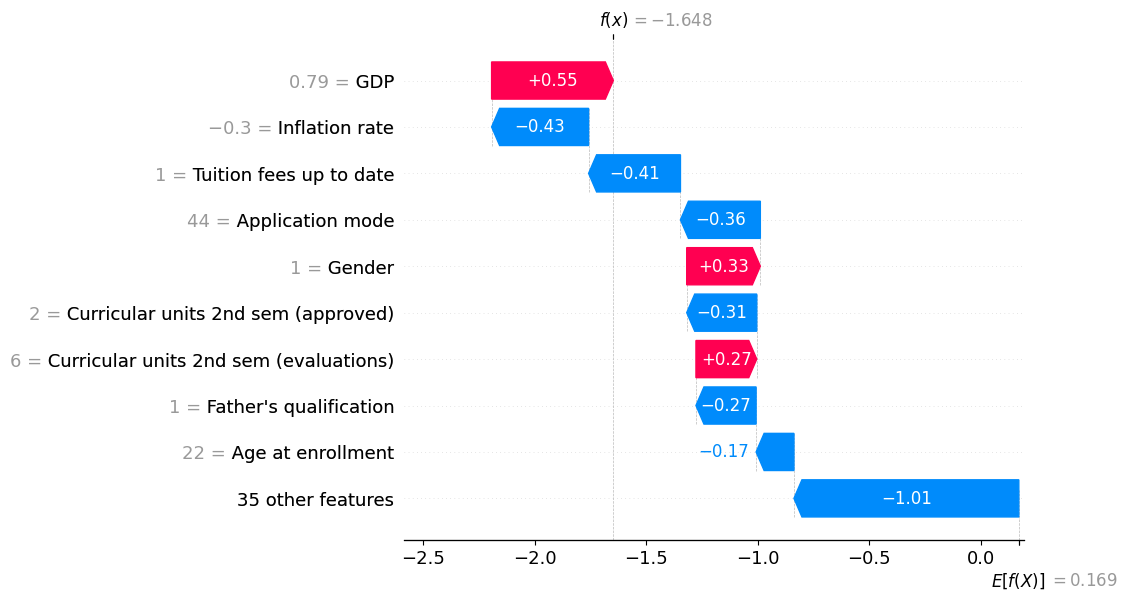

In [25]:
inner_calibrated = calibrated_cb_rm.calibrated_classifiers_[0]
final_pipe = inner_calibrated.estimator

fe = final_pipe.named_steps["fe"]
clf = final_pipe.named_steps["clf"]

X_test_fe = fe.transform(X_test)
feature_names = list(X_test_fe.columns)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_fe)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

if shap_values.shape[1] == X_test_fe.shape[1] + 1:
    shap_values = shap_values[:, :-1]

plt.title("SHAP Summary Plot – CatBoost (Final Calibrated Model)")
shap.summary_plot(shap_values, X_test_fe, feature_names=feature_names, show=True, plot_size=0.3)

shap.summary_plot(
    shap_values, X_test_fe, feature_names=feature_names,
    plot_type="bar", max_display=10, show=True
)

i = 420
explanation = shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=X_test_fe.iloc[i],
    feature_names=feature_names
)

shap.waterfall_plot(explanation)

### Robustness
#### Subgroup Performance

In [26]:
def subgroup_performance(X_test, y_test, model, group_col):
    results = []
    for value in sorted(X_test[group_col].unique()):
        idx = X_test[group_col] == value
        y_true_sub = y_test[idx]
        y_pred_sub = model.predict(X_test[idx])
        f1 = f1_score(y_true_sub, y_pred_sub, pos_label=1, zero_division=0)
        results.append({'Group': group_col, 'Value': value, 'F1 (Dropout)': f1, 'n': len(y_true_sub)})
    return pd.DataFrame(results)

attend_df = subgroup_performance(X_test, y_test, calibrated_cb_rm, 'Daytime/evening attendance\t')
gender_df = subgroup_performance(X_test, y_test, calibrated_cb_rm, 'Gender')
nationality_df = subgroup_performance(X_test, y_test, calibrated_cb_rm, 'Nationality')
international_df = subgroup_performance(X_test, y_test, calibrated_cb_rm, 'International')
course_df = subgroup_performance(X_test, y_test, calibrated_cb_rm, 'Course')

table = pd.concat([attend_df, gender_df, nationality_df, international_df,course_df])
print(table)

                           Group  Value  F1 (Dropout)    n
0   Daytime/evening attendance\t      0      0.870588   97
1   Daytime/evening attendance\t      1      0.796380  788
0                         Gender      0      0.804878  564
1                         Gender      1      0.811388  321
0                    Nationality      1      0.807018  859
1                    Nationality      2      0.000000    1
2                    Nationality      6      1.000000    3
3                    Nationality     22      0.000000    3
4                    Nationality     24      0.000000    2
5                    Nationality     26      1.000000    4
6                    Nationality     32      0.000000    1
7                    Nationality     41      1.000000    9
8                    Nationality    100      1.000000    1
9                    Nationality    105      0.000000    1
10                   Nationality    108      0.000000    1
0                  International      0      0.807018  8